In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import xgboost as xgb

import constants

In [2]:
def load_static_data():
    static_sensor_data=[]
    for sensor in constants.SENSOR_IDS:
        list_ = []
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/static/{}/{}.csv".format(date, sensor)
            df = pd.read_csv(filename,index_col=None)
            df['lat'] = constants.STATIC_COORDS[sensor][0]
            df['long'] = constants.STATIC_COORDS[sensor][1]
            # Calibration
            df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
            df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
            df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
            df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
            df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
            # -----------
            list_.append(df)
        static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))
    all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
    # Select columns
    all_static_data = all_static_data[constants.COLUMNS]
    all_static_data = all_static_data.dropna()
    print(len(all_static_data))
    all_static_data = clean_data(all_static_data)
    print(len(all_static_data))
    return all_static_data

def load_mobile_sensors():
    list_ = []
    for sensor in constants.MOBILE_SENSORS:
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/personal/{}/{}_{}.csv".format(date, sensor, date)
            df = pd.read_csv(filename,index_col=None)
            list_.append(df)
        mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
        mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
        mobile_sensor_data['long'] = mobile_sensor_data['longitude']
        # Calibration
        df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
        df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
        df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
        df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
        df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
        #Select columns
        mobile_sensor_data = mobile_sensor_data[constants.COLUMNS]
        if(sensor == 'XXE103'):
            mobile_sensor_data.index = mobile_sensor_data.index + pd.DateOffset(hours=1)
    print(len(mobile_sensor_data))
    mobile_sensor_data = clean_data(mobile_sensor_data)
    print(len(mobile_sensor_data))
    return mobile_sensor_data

#Transform to grid coordinates
def grid_lat_coord(lat):
    if lat < constants.LOWER_BOUND or lat > constants.UPPER_BOUND:
        return -1
    i = 0
    for lat_check in np.linspace(constants.LOWER_BOUND,constants.UPPER_BOUND,constants.GRID_SIZE+1)[1:]:
        if lat < lat_check:
            return constants.GRID_SIZE-1-i
        i+=1

def grid_long_coord(long):
    if long < constants.LEFT_BOUND or long > constants.RIGHT_BOUND:
        return -1
    i = 0
    for long_check in np.linspace(constants.LEFT_BOUND ,constants.RIGHT_BOUND,constants.GRID_SIZE+1)[1:]:
        if long < long_check:
            return i
        i+=1

def transform_to_grid_coordinates(data):
    data['lat_grid'] = data['lat'].apply(grid_lat_coord)
    data['long_grid'] = data['long'].apply(grid_long_coord)
    data = data[data['lat_grid'] >= 0]
    data = data[data['long_grid'] >= 0]
    return data

def setIds(data):
    startTime = constants.START_TIME
    endTime = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=5)).strftime("%Y-%m-%d %H:%M:%S")
    i = 0
    j = 0
    data['timestep'] = 0
    data['timestepContinuous'] = 0
    
    while startTime < constants.END_TIME:
        
        data['timestep'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), i, data['timestep'])
        i+=1
        
        if (data[(data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime)].shape[0] != 0):
            data['timestepContinuous'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), j, data['timestepContinuous'])
            j+=1
        startTime = endTime
        endTime = (datetime.strptime(endTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=constants.WINDOW)).strftime("%Y-%m-%d %H:%M:%S")

def add_land_type(data):
    data['land_type'] = np.vectorize(get_land_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['land_type'])
    data = data.join(one_hot)
    data.rename(columns={1.0: 'commercial', 2.0: 'residential', 3.0: 'green'}, inplace=True)
    data.drop(['land_type'],axis=1, inplace=True)
    
    return data

def get_land_type(x, y):
    return landuse[int(x)][int(y)]

def add_road_type(data):
    osm_dir = "/Users/ryanegan/Documents/diss/projectZoe/data/osm/"
    road_file = osm_dir + "roadtype_grid" + str(constants.GRID_SIZE) + ".csv"

    pd_df2=pd.read_csv(road_file, sep=',',header=None, skiprows=1)
    roadtype = pd_df2.values
    
    data['road_type'] = np.vectorize(get_road_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['road_type'])
    data = data.join(one_hot)
    data.rename(columns={0.0: 'primary', 1.0: 'secondary', 2.0: 'tertiary', 3.0: 'unclassified', 4.0: 'residential/service', 5.0: 'pedestrian/cycle/noroad'}, inplace=True)
    data.drop(['road_type'],axis=1, inplace=True)
    
    return data

def get_road_type(x, y):
    return roadtype[int(x)][int(y)]

def add_labels(data):
    data['next_pm_2.5'] = np.vectorize(get_next_pm)(data['lat_grid'], data['long_grid'], data['timestep'])
    return data

def get_next_pm(lat, long, timestep):
    for i in range(constants.GRID_SIZE):
        next_data = all_data[(np.abs(all_data['lat_grid'] - lat) <= i) & (np.abs(all_data['long_grid'] - long) <= i) & (all_data['timestep'] == timestep + 1)]
        if(not next_data.empty):
            next_pm = next_data['PM2.5'].mean()
            return next_pm

def add_previous(data):
    data['prev_pm_2.5'] = np.vectorize(get_previous_pm)(data['lat_grid'], data['long_grid'], data['timestep'])
    return data

def get_previous_pm(lat, long, timestep):
    for i in range(constants.GRID_SIZE):
        prev_data = all_data[(np.abs(all_data['lat_grid'] - lat) <= i) & (np.abs(all_data['long_grid'] - long) <= i) & (all_data['timestep'] == timestep - 1)]
        if(not prev_data.empty):
            prev_pm = prev_data['PM2.5'].mean()
            return prev_pm
        
def clean_data(data):
    data = data.loc[data["PM2.5"].shift() != data["PM2.5"]]
    return data

    

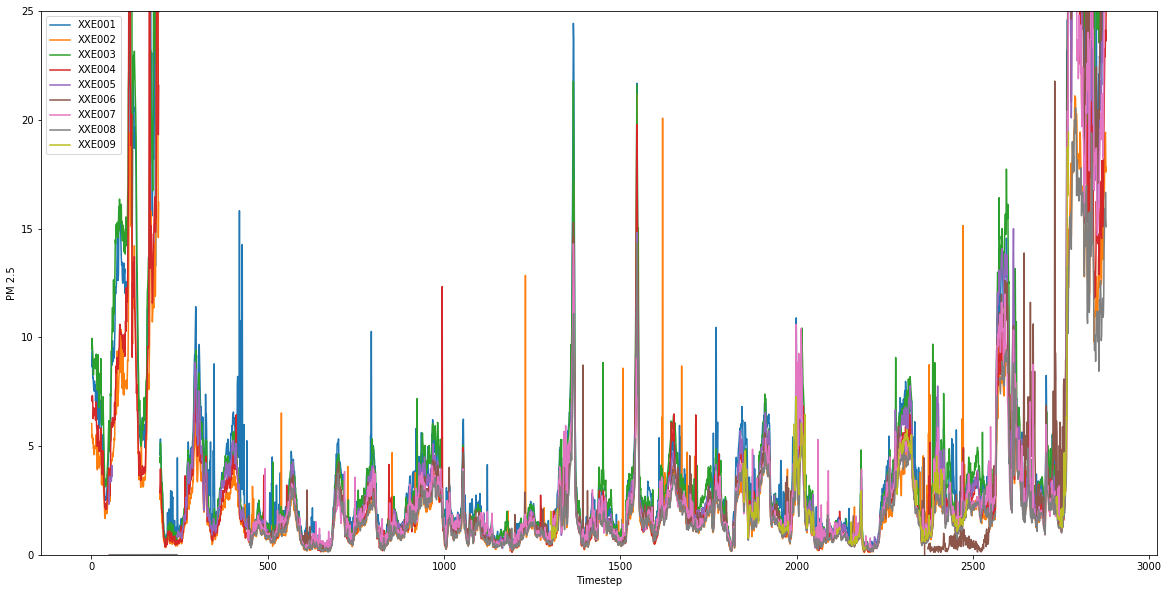

In [12]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%d T%H:%M Z') for dt in 
       datetime_range(datetime(2018, 6, 28, 0), datetime(2018, 8, 8, 11+12), 
       timedelta(minutes=15))]



with open("grid_labels_20_2019.txt", "rb") as fp:   # Unpickling
    grid_labels = pickle.load(fp)

labels = ['XXE001', 'XXE002', 'XXE003', 'XXE004', 'XXE005', 'XXE006', 'XXE007', 'XXE008', 'XXE009','XXE010']
plt.figure(figsize=(20,10))
plt.xlabel('Timestep')
plt.ylabel('PM 2.5')
for j, coord in enumerate(constants.STATIC_COORDS_GRID.values()):
    x = int(coord[0])
    y = int(coord[1])
    real_values = []
    for i in range(len(grid_labels)):
        real_values.append(grid_labels[i][x][y])
    plt.plot(real_values,
           label=labels[j])
plt.ylim([0,25])
plt.legend()
plt.savefig('all_data_2019.png')
plt.show()

In [3]:
staticData = load_static_data()
staticData = transform_to_grid_coordinates(staticData)
mobileData = load_mobile_sensors()
mobileData = transform_to_grid_coordinates(mobileData)
all_data = pd.concat([staticData, mobileData], ignore_index=True)
setIds(all_data)

all_data['hour'] = all_data.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').hour, axis=1)
all_data['minute'] = all_data.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').minute, axis=1)

columns= constants.UPDATED_COLUMNS
allData15 = pd.DataFrame(columns=columns)
for timestep in range(all_data['timestepContinuous'].max()):
    print(timestep)
    for x in range(constants.GRID_SIZE):
        for y in range(constants.GRID_SIZE):
            curData = all_data[(all_data['lat_grid'] == x) & (all_data['long_grid'] == y) & (all_data['timestepContinuous'] == timestep)]
            if(not curData.empty):
                curData = curData.mean(axis = 0)
                allData15.loc[len(allData15)] = curData
all_data = allData15




77537
76740
7399
7010


In [4]:
osm_dir = "/Users/ryanegan/Documents/diss/projectZoe/data/osm/"
LU_file = osm_dir + "landuse_grid" + str(constants.GRID_SIZE) + ".csv"
road_file = osm_dir + "roadtype_grid" + str(constants.GRID_SIZE) + ".csv"

pd_df1=pd.read_csv(LU_file, sep=',',header=None, skiprows=1)
landuse = pd_df1.values
pd_df2=pd.read_csv(road_file, sep=',',header=None, skiprows=1)
roadtype = pd_df2.values


all_data = add_land_type(all_data)
all_data = add_road_type(all_data)
all_data = add_labels(all_data).dropna()
all_data = add_previous(all_data)

all_data = all_data.dropna()

with open("all_data_15_min_" + str(constants.GRID_SIZE)+ "_grid_2019_small.txt", "wb") as fp:   #Pickling
    pickle.dump(all_data, fp)
    

In [5]:
def realValueGrid(data):
    values = []
    for i in range(int(data['timestepContinuous'].max())):
        print(i)
        value_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
        cur_data = data[data['timestepContinuous'] == i]
        #Get list of all coords
        if(not cur_data.empty):
            lat_coords = np.array(cur_data['lat_grid'])
            long_coords = np.array(cur_data['long_grid'])

            for col, row in zip(lat_coords, long_coords):
                col = int(col)
                row = int(row)

                new_label = cur_data[(cur_data['lat_grid'] == col) & (cur_data['long_grid'] == row)]['PM2.5']
                new_label = new_label.mean()
                value_matrix[col][row] = new_label
        values.append(value_matrix)
    return values

In [6]:
with open("all_data_15_min_" + str(constants.GRID_SIZE) + "_grid_2019_small.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)

label_grid = realValueGrid(all_data)
with open("grid_labels_" + str(constants.GRID_SIZE)+ "_2019_small.txt", "wb") as fp:   #Pickling
    pickle.dump(label_grid, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
